# Keras Tutorial
Keras is a high-level neural networks library for Python capable of running on top of TensorFlow, Theano and other lower level frameworks. What makes keras special is that it is extremely user friendly: its syntax focuses on the big ideas, and takes care of a lot of the detailed plumbing, that can make these topics seems extremely complicated. For these reasons it is the ideal deep-learning package for beginners (although the fast-experimentation enabled by its simplicity has made it popular among serious researchers too).

## Keras Structure
The keras package is broken down into multiple parts, each describing a different part of neural network pipeline.
1. Models (`keras.models`): This governs the overall type of architecture of the  neural network. In our case, we go from a single input to output, and therefore use a `sequential` model. Other model types for reccurrent networks etc can also be found here.
2. Layers (`keras.layers`): neural networks are built up as asequence of layers. These layers can be of many types Fully connected `dense` layers as we use here, and 2D convolutional (`conv2D`) layers that you will see soon are two well known examples.
3. Optimizers (`keras.optimizers`): This is what keras uses to learn the neural network weights etc from the training data.
4. Sample Data (`keras.datasets`): Like scikit learn, keras comes with several popular machine learning data sets to make it easy to benchmark and test our neural network architectures.
5. Utils (`keras.utils`): Various utility functions to make our lives easier. Here we will use a function to draw a diagram depicting our network.

In [1]:
# Lets import the various libraries we need
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

Using TensorFlow backend.


## The Data
For this exercise (and the next one) will will be using the classic MNIST dataset. Like the digits data you had used earlier, these are pictures of numbers. The big difference is the pictures are bigger (28x28 pixels rather than 8x8) and we will be looking at a much larger data set: 60,000 training images and 10,000 to test. See sample pictures by running the code below.

Data structure:
* As with the digits data earlier, we will "unwrap" the 28x28 square arrays into 784 dimensional vectors
* With 60,000 input images this gives us an input matrix `x_train` of dimensionality 60,000 x 784 (and a 10,000 x 784 matrix `x_test`for the test data)
* For each of these images we have a true class label `y_test` and `y_train`, which is a number between 0 and 9 corresponding to the true digit.Thus `num_classes=10`
* Below we reshape this label data into a "binary" format for ease of comparison. Each element in `y_test` is represented by a 10 dimensional vector, with a 1 corresponding to the correct label and all the others zero.
* Thus our "output" vector dimensionality will 60,000 x 10 (and a 10,000 x 784 matrix `x_test`for the test data)

60000 train samples
10000 test samples


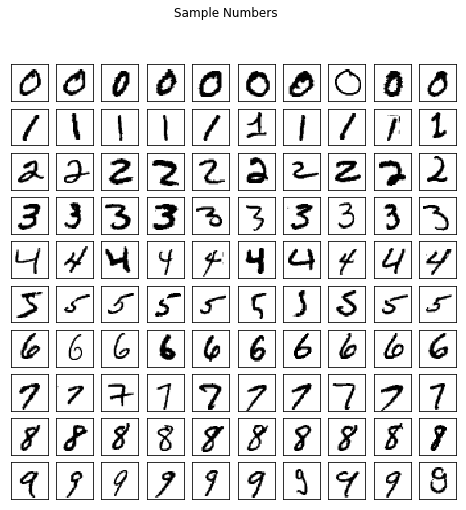

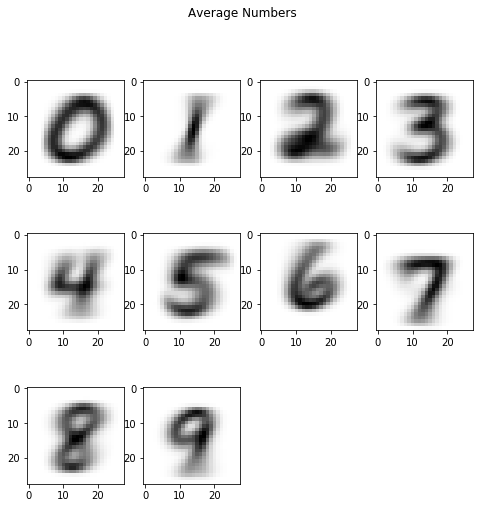

In [2]:
# Load Mnist data
# the data, split between train and test sets
num_classes = 10 # we have 10 digits to classify
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


# Plot sample pictures
fig = plt.figure(figsize=(8, 8))
classNum=np.zeros((y_train.shape[0],1))
for i in range(y_train.shape[0]):
    classNum[i]=np.where(y_train[i,:])

meanVecs=np.zeros((num_classes,784))    
nReps=10
counter=1
for num in range(num_classes):
    idx =np.where(classNum==num)[0]
    meanVecs[num,:]=np.mean(x_train[idx,:],axis=0)
    for rep in range(nReps):
        mat=x_train[idx[rep],:]
        mat=(mat.reshape(28,28))
        ax = fig.add_subplot(num_classes,nReps,counter)
        plt.imshow(mat,cmap=plt.cm.binary)
        plt.xticks([])
        plt.yticks([])
        counter=counter+1
plt.suptitle('Sample Numbers')
plt.show()

# Plot "Average" Pictures
fig = plt.figure(figsize=(8, 8))

for num in range(num_classes):
    
    mat=(meanVecs[num,:].reshape(28,28))
    ax = fig.add_subplot(3,4,num+1)
    plt.imshow(mat,cmap=plt.cm.binary)
plt.suptitle('Average Numbers')
plt.show()


## Building the model
We're now ready to build our first neural network model. We'll begin with the easiest model imaginable given the data. A network where eeach one of the 784 pixels in the input data is connected to each of the 10 output classes.
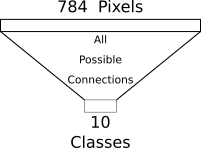
This network essentially just has a single layer (it is both the first and last layer), and is essentially just a matrix 784x10 matrix, which multiplies the 784 pixel input vector to produve a 10 dimensional output. This is not deep yet, but we'll get to adding more layers later.

### Step 1:Define the Model
In this case there is one set of input going forward to a single set of outputs with no feedback. This is called a sequential model. We can thus create the "shell" for such a model by declaring:

In [10]:
model = Sequential()

The variable `model` will contain all the information on the model, and as we add layers and perform calculations, it will all be stored insidle this variable.

### Step II: Adding a (input) layer
In general adding a layer to a mode is achieved by the `model.add(layer_definition)` command. Where the layer_definition is specific to the kind of layer we want to add.

Layers are defined by 4 traits:
1. The layer type: Each layer type will have its own function in keras like `Dense` for a fully-connected layer, `conv2d` of a 2D convolutional layer and so on. 
2. The output size: This is the number of outputs emerging after the layer, and is specified as the first argument to the layer function.
    - In our case the output size is `num_classes=10`
3. The input size: This is the number of inputs coming in to the function. 
    - In general, **** except for the input layer, keras is smart enough to figure out the input size based on the preceding layers**** 
    - We need to explicitly specify the size of the input layer as an `input_shape=` parameter.
4. Activation: This is the non-linear function used to transform the integrated inputs into the output. E.g. '`relu` is the rectified-linear-unit transform. For a layer connecting to the output, we want to enforce a binary-ish response, and hence the last-layer will often contain a `softmax` activation.

Note: in our super-simple first case, the first layer is essentially the last layer. which why we end up providing both the `input_shape=` and using `softmax`. This will not be the case for deeper networks.

So we can add our (`Dense`) fully connected layer with `num_classes` outputs, `softmax` activation and 784 pixel inputs as:

In [11]:
model.add(Dense(num_classes, activation='softmax', input_shape=(784,)))


Note the `input_shape=(784,)` here. 784 is the size of out input images. The `(784,)` means we can have an unspecified number of input images coming into the network.

Normally, we would keep adding more layers (see examples later). But in this case we only have one layer. So we can see what our model looks like by invoking:

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Whenever you build a model be sure to look at the summary. The number of trainable parameters gives you a sense of model complexity. Models with fewer parameters are likely to be easier to train, and likely to generalize better for the same performance.

### Step III: Compile the model
This step describes how keras will update the  model during the training phase (this is defining some of the parameters for this calculation).

There are two choices we make here:
1. How to define the loss: This defines how we penalize disagreement of the output of the classifier with respect to the true labels. There are several options (https://keras.io/losses/), but for a multi-class problem such as this with a binary encoding `categorical_crossentropy` is a popular choice that penalizes high-confidence mistakes.
2. The optimizer: Optimization is performed using some form of gradient descent. But there are several choices on exactly how this is performed (https://keras.io/optimizers/ and http://ruder.io/optimizing-gradient-descent/). Here we choose to go with `RMSprop()` a popular choice. The parameters of the optimizer, such as learning rate, can also be specified as parameters to the optimization function, but we will use default values for now.

We also choose to report on the accuracy during the optimization process, to keep track of progress:

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

### Step IV: Train the model
We're now ready to perform the training. A couple more decisions need to be made:
1. How long to train: This is measured in "epochs", each epoch representing the whole training data going through the algorithm. You want to give the optimizer long enough so it can get to a good solution, but you will hit a point of diminishing returns (more on this later, and in the exxercises)
2. Batch Size: the network is updated by splitting the data into mini-batches and this is the number of data points used for each full update of the weights. Increasing batch size, will lead to larger memory requirements etc. 

With these parameters we can fit the model to our training data as follows. This will produce a nice plot updating the accuracy (% of correctly classified points in the training data):

In [14]:
batch_size = 128
epochs = 20
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)


Epoch 1/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.6011 - acc: 0.8502
Epoch 2/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.3306 - acc: 0.9077
Epoch 3/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.3015 - acc: 0.9157
Epoch 4/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.2881 - acc: 0.9202
Epoch 5/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.2798 - acc: 0.9221
Epoch 6/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.2745 - acc: 0.9234
Epoch 7/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.2705 - acc: 0.9250
Epoch 8/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.2674 - acc: 0.9261
Epoch 9/20
60000/60000 [==============================] - 1s 16us/step - loss: 0.2647 - acc: 0.9269
Epoch 10/20
60000/60000 [==============================] - 1s 16us/step - loss: 0.2626 - acc: 0.9283

### Step V: Test the model
The real test of a model is how well it does on the training data (a severly overfit model could get 100% accuracy on training data, but fail miserably on new data). So the real score we care about is the performance on un-seen data. We do this by evaluating performance on the test data we held out so far. The code below also makes a plot showing the confidence curve on the training data, and a flat line corresponding to the performance on the new data. 

#### Questions:
1. What does the deviation between these two curves tell us?
2. What do you think would happen if we continued training?  Feel free to test.

Test loss: 0.269337419346
Test accuracy: 0.9283


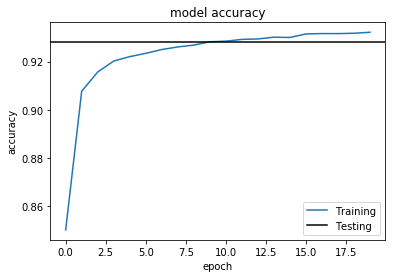

In [15]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig = plt.figure()
trainCurve=plt.plot(history.history['acc'],label='Training')
testCurve=plt.axhline(y=score[1],color='k',label='Testing')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Interpreting the results
Since we used an incredibly simple network, it is easy to look under the covers and see what is going on. For each class (i.e. digit=1 to 9) this simple network essentially has a filter-matrix the same size as the image, which it "multiplies" an input image against. The digit for which the filter produces the highest response is the chosen digit. We can look at the filter matrices by looking at the weights of the first layer.  

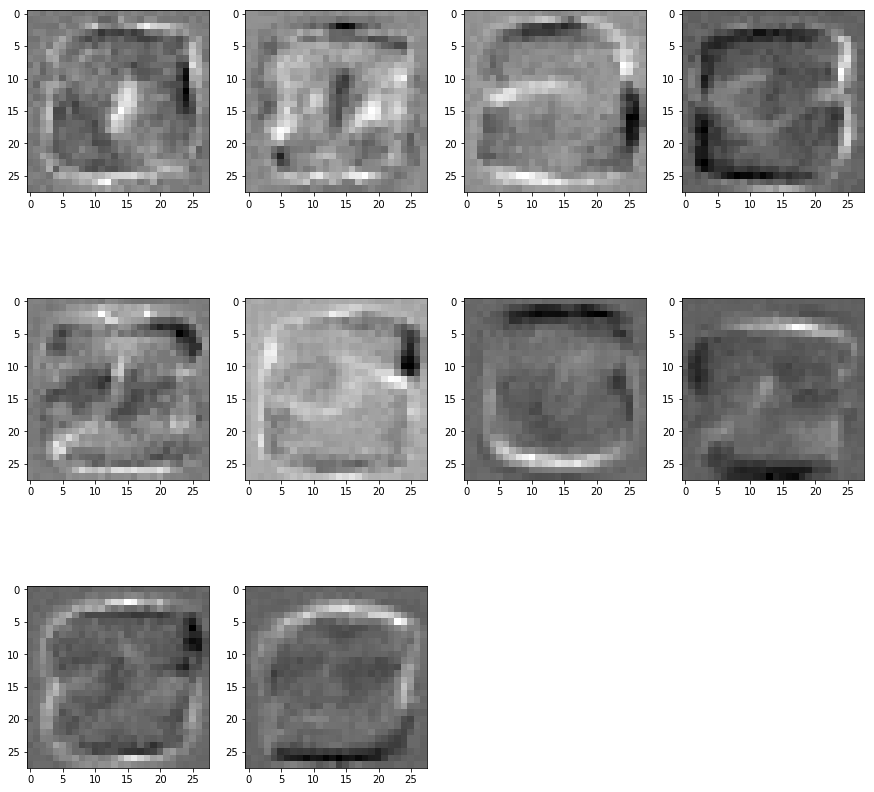

In [20]:
denseLayer=model.layers[0]
weights=denseLayer.get_weights()
topWeights=weights[0]
fig = plt.figure(figsize=(15, 15))
meanTop=np.mean(topWeights,axis=1)
for num in range(topWeights.shape[1]):
    mat=topWeights[:,num]-meanTop
    mat=(mat.reshape(28,28))
    ax = fig.add_subplot(3,4,num+1)
    plt.imshow(mat,cmap=plt.cm.binary)
plt.show()
#fig=plt.figure()
#plt.imshow(meanTop.reshape(28,28),cmap=plt.cm.binary)
#plt.show()

#### Questions:
Compare the results of these weights to the mean digit images at the beginning of this notebook:
1. Can you explain the form of these curves? Why does the first one have a white spot (low value) at the center while the second has a high value there?
2. What do you think the limitations of this approach are? What might we gain by adding more layers?

## Building a deeper network
We will build a deeper 3-layer network, following exactly the same steps, but with 2-additional layers thrown in. FYI, this topology comes from one of the examples provided by keras at https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py 
* Note the changes to the input layer below (output size and activation).
* There is a new intermediate dense layer. This takes the 512 outputs from the input layer and connects them to 512 outputs.
* Then the final layer connects the 512 inputs from the previous layer to the 10 needed outputs.

In [23]:

# Model initialization unchanged
model = Sequential()
# Input layer is similar, but because it doesn't connect to the final layer we are free
# to choose number of outputs (here 512) and we use 'relu' activation instead of softmax. It also 
model.add(Dense(512, activation='relu', input_shape=(784,)))
# New intermediate layer connecting the 512 inputs from the previous layer to the 512 new outputs
model.add(Dense(512, activation='relu'))
# The 512 inputs from the previous layer connect to the final 10 class outputs, with a softmax activation
model.add(Dense(num_classes, activation='softmax'))

# Compilation as before
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#Image("model_plot.png")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_14 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


Note the dramatic increase in the number of parameters achieved with this network. When you train this network, you'll see that this increase in number of parameters really slows things down, but leads to an increase in performance:

Epoch 1/40
60000/60000 [==============================] - 1s 24us/step - loss: 0.2194 - acc: 0.9328
Epoch 2/40
60000/60000 [==============================] - 1s 21us/step - loss: 0.0812 - acc: 0.9748
Epoch 3/40
60000/60000 [==============================] - 1s 22us/step - loss: 0.0520 - acc: 0.9841
Epoch 4/40
60000/60000 [==============================] - 1s 23us/step - loss: 0.0379 - acc: 0.9880
Epoch 5/40
60000/60000 [==============================] - 1s 22us/step - loss: 0.0290 - acc: 0.9909
Epoch 6/40
60000/60000 [==============================] - 1s 22us/step - loss: 0.0220 - acc: 0.9930
Epoch 7/40
60000/60000 [==============================] - 1s 23us/step - loss: 0.0190 - acc: 0.9944
Epoch 8/40
60000/60000 [==============================] - 1s 22us/step - loss: 0.0162 - acc: 0.9949
Epoch 9/40
60000/60000 [==============================] - 1s 22us/step - loss: 0.0130 - acc: 0.9960
Epoch 10/40
60000/60000 [==============================] - 1s 22us/step - loss: 0.0115 - acc: 0.9966

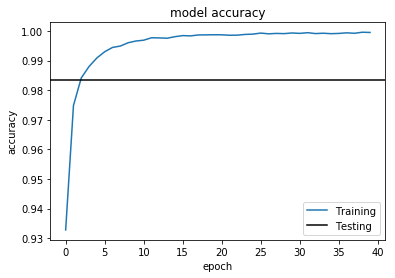

In [24]:
batch_size = 128
epochs = 20
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig = plt.figure()
trainCurve=plt.plot(history.history['acc'],label='Training')
testCurve=plt.axhline(y=score[1],color='k',label='Testing')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

#### Questions:
* What do you think about the agreement between the training and testing curves?
* Do you think there is a qualitative difference in what this classifier picks up? 

We can get some clues by looking at the input layer as before. Although now there are 512 instead of 10 filters. So we just look at the first 10.

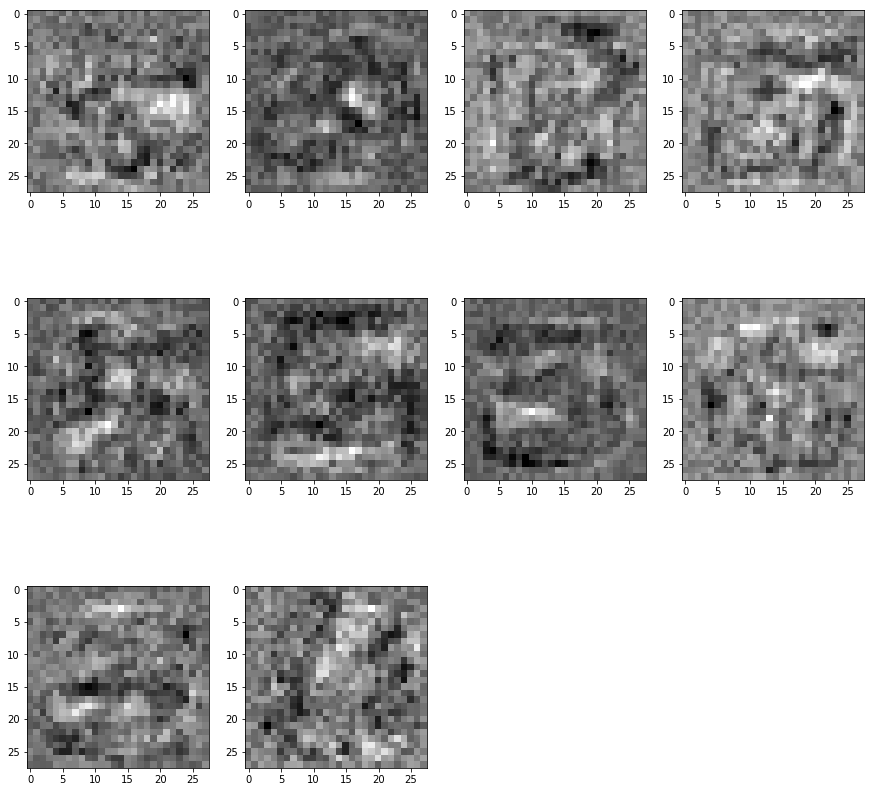

In [28]:
denseLayer=model.layers[0]
weights=denseLayer.get_weights()
topWeights=weights[0]
fig = plt.figure(figsize=(15, 15))
meanTop=np.mean(topWeights,axis=1)
for num in range(10):
    mat=topWeights[:,num]-meanTop
    mat=(mat.reshape(28,28))
    ax = fig.add_subplot(3,4,num+1)
    plt.imshow(mat,cmap=plt.cm.binary)
plt.show()

What is the quaitative difference between these plots and 

## Overfitting
As you can see with the increase in the number of parameters, there is an increase in the mismatch between training and testing, raising the concern that the model is overfitting on the training data. There are a couple of approaches to combat this. 
1. Dropout
2. Don't train so hard!

Dropout is a way of introducing noise into the model to prevent overfitting. It is implemented by adding dropout layers. These layers randomly set a specified fraction of input units to zeros (at each update during training). Below is the same model implemented with dropout layers added. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
60000/60000 [==============================] - 2s 28us/step - loss: 0.2460 - acc: 0.9242
Epoch 2/20
60000/60000 [============

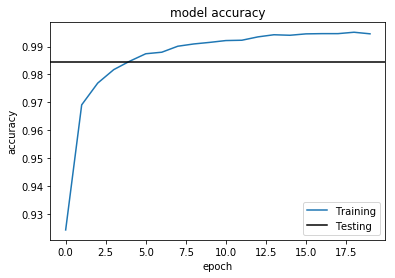

In [29]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
# NEW dropout layer dropping 20% of inputs
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
# NEW dropout layer dropping 20% of inputs
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))


# Compilation as before
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#Image("model_plot.png")
model.summary()
batch_size = 128
epochs = 20
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig = plt.figure()
trainCurve=plt.plot(history.history['acc'],label='Training')
testCurve=plt.axhline(y=score[1],color='k',label='Testing')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Exercises & Questions
1. What do you think would happen with increased dropout? Feel freee to experiment
2. What is the effect of training too long? Repeat these experiments of more or fewer epochs. What does that do?
3. Play with the (hyper-parameters) parameters. We don't have to use 2 layers with 512 outputs. Change things around and see how sensitive the results are.
4. Is it fair to keep doing this and using the topology that gives the best performance on the testing data?